importing Jupyter notebook from Mymodels.ipynb
importing Jupyter notebook from Preprocess.ipynb
importing Jupyter notebook from Research.ipynb


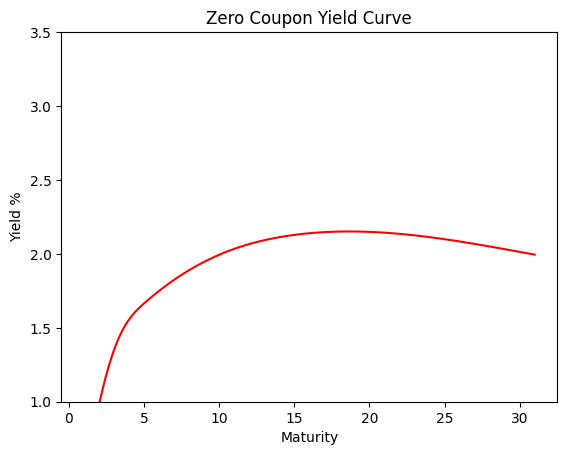

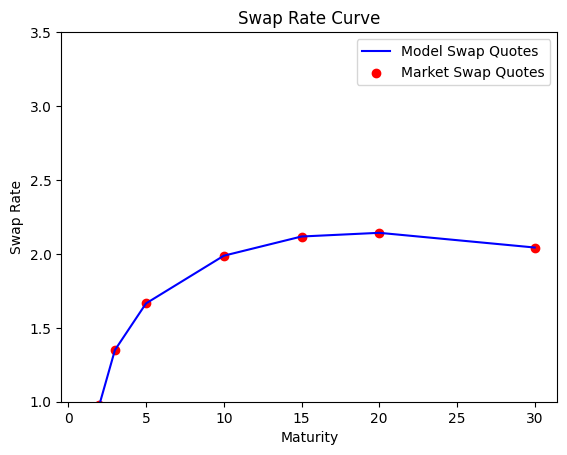

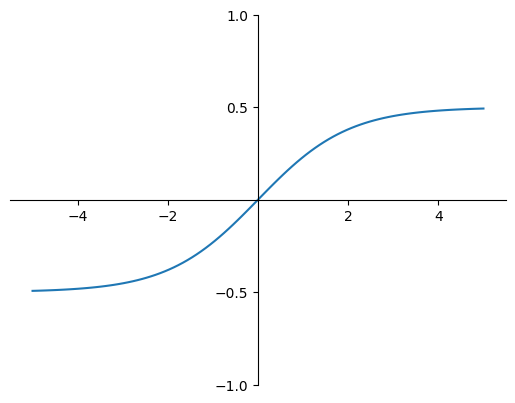

In [1]:
# Python packages


import import_ipynb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torchvision import datasets
from torchvision import transforms
import Mymodels

import Preprocess
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)
from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
from scipy.optimize import newton,least_squares
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from torch.func import hessian
import math
from torch.func import jacfwd
from torch.func import vmap, vjp
import Research

In [20]:
# Load of model and data

# load trained model:
in_features = 8
latent_dim = 2

model_name = "model_5000_2finnae_w5"

model_path = "/models/{}".format(model_name)

AE_model = Mymodels.FIRAutoEncoder(in_features,latent_dim)
optimizer = torch.optim.Adam(AE_model.parameters(), lr=0.01)
    
model_load = torch.load(model_path)
AE_model.load_state_dict(model_load['model_state_dict'])

# Default maturities
maturities = np.linspace(0,30,31,endpoint=True)
swap_maturities = [1,2,3,5,10,15, 20, 30]

# Data load
data_path = 'data/BloombergData/'
data_path_test = 'data/TestData/'

prefix = ['ad','cd','nk','sw','dk','EU','US','uk','jy']
prefix_test = ['ad', 'cd', 'nk', 'sw','dk','EU','jy']

postfix = ["1year.xlsx", "2year.xlsx", "3year.xlsx","5year.xlsx","10year.xlsx","15year.xlsx","20year.xlsx","30year.xlsx"]


date_start = "2009-12-31"
date_end = "2023-01-01"

date_start_test1 = "2001-01-01"
date_end_test1 = "2009-12-31"

date_start_test2 = "2023-01-01"
date_end_test2 = "2026-12-31"


# load of train,val and both test data sets.
x_train, x_val= Preprocess.data_clean(Preprocess.init_cleaning(prefix, postfix, data_path, date_start, date_end))
x_test1 = Preprocess.data_clean_test(Preprocess.init_cleaning(prefix_test, postfix, data_path_test, date_start_test1, date_end_test1))
x_test2 = Preprocess.data_clean_test(Preprocess.init_cleaning(prefix_test, postfix, data_path_test, date_start_test2, date_end_test2))
x_train_full = Preprocess.data_clean_test(Preprocess.init_cleaning(prefix, postfix, data_path, date_start, date_end))


# dictionary for ensuring that the loss can be calculated currency wise
dict_train = {"dk": [], "sw": [], "EU": [], "US": [], "jy": [], "nk": [], "cd": [], "ad": [], "uk": []}
dict_test = {"dk": [], "sw": [], "EU": [], "jy": [], "nk": [], "cd": [], "ad": []}

# function for creating dictonary
def data_stuff(x_array, dict):
    for x in x_array:
        key, value = x[0], x[1:]
        dict[key].append(value / 100)
        
    return dict

In [8]:
# Function for calculating the everything a 2-factor AE model produces, i.e. loss, arbitrage loss, sigma, mu etc.

def loss_calc_ae2(model, x, maturities, swap_maturities):
    model.eval()
    final_swaps = []
    sigma1s = []
    latent_space = []
    mu1s = []
    mu2s = []
    sigma2s = []
    yield_curves = []
    rhos = []
    short_rates = []
    rmse = 0
    arbitrage_loss = 0
    for swaps in x:
        regulizer_curve = []
        swaps = torch.from_numpy(np.array(swaps,dtype=np.float64))
        encoded = model.encoder(swaps)
        decoded = []    
        for i in maturities:
            taus = torch.tensor([i])
            decoded.append(model.decoder(torch.cat((encoded, taus))))
        mu = model.drift(encoded)
        sigma_1, sigma_2, rho = torch.split(model.volatility(encoded),1)
        decode = torch.stack(decoded,dim=1)

        short_rate = decoded[0]        
        mu1,mu2 = torch.split(mu,1)
        maturities_1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
        yield_curve = decode
        for tau in maturities_1:
            latents = torch.unsqueeze(encoded, 0)
        
            taus = torch.full((latents.size()[0], 1), tau)
            compute_batch_jacobian = vmap(jacfwd(model.decoder,argnums=0), in_dims=(0)) 
            latent_grad = compute_batch_jacobian(torch.cat((latents,taus), dim=1))
            

            compute_batch_hessian = vmap(hessian(model.decoder, argnums=0), in_dims=(0))
            hessian_z = compute_batch_hessian(torch.cat((latents,taus), dim=1)) 

            removed_row = hessian_z[:, :, :-1, :]
            hessian_z = removed_row[:, :, :, :-1]
            hessian_z = torch.squeeze(hessian_z,dim=1)

            
            grad_z = latent_grad[:, :, :2]  
            grad_tau = latent_grad[:, :, 2:]  
            grad_tau = torch.squeeze(grad_tau, dim=2)
            grad_z = torch.squeeze(grad_z, dim=2)

            mu = model.drift(encoded)
            mu1,mu2 = torch.split(mu,1)
            sigma_1, sigma_2, rho = torch.split(model.volatility(torch.unsqueeze(encoded, 0)) , 1 , dim=1)
     
                
            sigma = Mymodels.construct_sigma2(torch.exp(sigma_1), torch.exp(sigma_2), torch.tanh(rho))



            regulizer_curve.append(Mymodels.arbitrage_condition2(model.decoder(torch.cat((encoded, torch.tensor([taus])))), short_rate, grad_tau,grad_z,torch.unsqueeze(mu,0),sigma,hessian_z))


        latent_space.append((latents.detach().numpy()).flatten())
        short_rates.append(short_rate)
        yield_curves.append(yield_curve)
        sigma1s.append(torch.exp(sigma_1))
        sigma2s.append(torch.exp(sigma_2))
        mu1s.append(mu1)
        mu2s.append(mu2)
 
        swaps_calc = []
        
        for i in range(len(decode)):
            swaps_calc.append(Mymodels.swap_rate_torch_paper(decode[i], swap_maturities))
        final_swaps.append(swaps_calc)
        result_swaps = torch.stack(swaps_calc,dim=0)
        rmse += torch.sqrt(torch.sum(torch.pow((result_swaps-swaps), 2),1)/8) * 10000
        arbitrage_loss += torch.sqrt((torch.sum(torch.pow(torch.cat(regulizer_curve, dim=1), 2), 1)/30 * 1))*10000
        regulizer_curve = []
    return (rmse + arbitrage_loss)/len(x),final_swaps, swaps, rmse/len(x), arbitrage_loss/len(x), sigma1s,sigma2s, mu1s, mu2s,rhos, short_rates,yield_curves,latent_space 

In [9]:
# Function for calculating the everything a 3-factor AE model produces, i.e. loss, arbitrage loss, sigma, mu etc.

def loss_calc_ae3(model, x, maturities, swap_maturities):
    model.eval()
    final_swaps = []
    sigma1s = []
    mu1s = []
    mu2s = []
    mu3s = []
    sigma2s = []
    sigma3s = []
    rho12s = []
    rho13s = []
    rho23s = []
    latent_space = []
    yield_curves = []
    short_rates = []
    rmse = 0
    arbitrage_loss = 0
    for swaps in x:
        regulizer_curve = []
        swaps = torch.from_numpy(np.array(swaps,dtype=np.float64))
        encoded = model.encoder(swaps)
        decoded = []    
        for i in maturities:
            taus = torch.tensor([i])
            decoded.append(model.decoder(torch.cat((encoded, taus))))
        mu = model.drift(encoded)
        
        decode = torch.stack(decoded,dim=1)
        yield_curve = decode
        short_rate = decoded[0]

        mu1,mu2, mu3 = torch.split(mu,1)
        maturities_1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
        for tau in maturities_1:
            latents = torch.unsqueeze(encoded, 0)


            taus = torch.full((latents.size()[0], 1), tau)
            compute_batch_jacobian = vmap(jacfwd(model.decoder,argnums=0), in_dims=(0)) 
            latent_grad = compute_batch_jacobian(torch.cat((latents,taus), dim=1))
            
            compute_batch_hessian = vmap(hessian(model.decoder, argnums=0), in_dims=(0))
            hessian_z = compute_batch_hessian(torch.cat((latents,taus), dim=1)) 

            removed_row = hessian_z[:, :, :-1, :]
            hessian_z = removed_row[:, :, :, :-1]
            hessian_z = torch.squeeze(hessian_z,dim=1)

            
            grad_z = latent_grad[:, :, :3]  
            grad_tau = latent_grad[:, :, 3:]  
            grad_tau = torch.squeeze(grad_tau, dim=2)
            grad_z = torch.squeeze(grad_z, dim=2)
            
            sigma_1, sigma_2, sigma_3, rho12, rho13, rho23 = torch.split(model.volatility(torch.unsqueeze(encoded, 0)) , 1 , dim=1)
            sigma = Mymodels.construct_sigma3(torch.exp(sigma_1), torch.exp(sigma_2), torch.exp(sigma_3), torch.tanh(rho12), torch.tanh(rho13), torch.tanh(rho23))
            
            mu = model.drift(encoded)
            mu1,mu2, mu3 = torch.split(mu,1)


            regulizer_curve.append(Mymodels.arbitrage_condition3(model.decoder(torch.cat((encoded, torch.tensor([tau])))), short_rate, grad_tau,grad_z,torch.unsqueeze(mu,0),sigma,hessian_z))


        short_rates.append(short_rate)
        sigma1s.append(torch.exp(sigma_1))
        sigma2s.append(torch.exp(sigma_2))
        sigma3s.append(torch.exp(sigma_3))
        mu1s.append(mu1)
        mu2s.append(mu2)
        mu3s.append(mu3)
        rho12s.append(torch.tanh(rho12))
        rho13s.append(torch.tanh(rho13))
        rho23s.append(torch.tanh(rho23))
        yield_curves.append(yield_curve)
        latent_space.append((latents.detach().numpy()).flatten())

        swaps_calc = []
        
        for i in range(len(decode)):
            swaps_calc.append(Mymodels.swap_rate_torch_paper(decode[i], swap_maturities))
        final_swaps.append(swaps_calc)
        result_swaps = torch.stack(swaps_calc,dim=0)
        rmse += torch.sqrt(torch.sum(torch.pow((result_swaps-swaps), 2),1)/8) * 10000
        arbitrage_loss += torch.sqrt((torch.sum(torch.pow(torch.cat(regulizer_curve, dim=1), 2), 1)/30 * 1))*10000
        regulizer_curve = []
    return (rmse + arbitrage_loss)/len(x),final_swaps, swaps, rmse/len(x),  arbitrage_loss/len(x), sigma1s,sigma2s, sigma3s, mu1s, mu2s,mu3s, rho12s,  rho13s, rho23s, short_rates,yield_curves,latent_space


In [10]:
# Function for calculating the everything a 2-factor VAE model produces, i.e. loss, arbitrage loss, sigma, mu etc.


def loss_calc_vae2(model, x, maturities, swap_maturities):
    model.eval()
    final_swaps = []
    sigma1s = []
    mu1s = []
    mu2s = []
    sigma2s = []
    yield_curves = []
    rhos = []
    short_rates = []
    latent_space=[]
    rmse = 0
    arbitrage_loss = 0
    kld_loss = 0
    for swaps in x:
        regulizer_curve = []
        swaps = torch.from_numpy(np.array(swaps,dtype=np.float64))
        encoded = model.encoder(swaps)
        mean1, var1 = torch.split(model.encoder1(encoded), 1)
        mean2, var2 = torch.split(model.encoder2(encoded), 1)
       
        var1 = torch.exp(var1)
        var2 = torch.exp(var2)

        N = torch.distributions.Normal(0, 1)
        
        z1 = mean1 + var1*N.sample(mean1.shape)
        z2 = mean2 + var2*N.sample(mean2.shape)

        encoded = torch.cat((z1,z2))
        mean = torch.cat((mean1, mean2))
        var = torch.cat((var1, var2))



        decoded = []    
        for i in maturities:
            taus = torch.tensor([i])
            decoded.append(model.decoder(torch.cat((encoded, taus))))
        mu = model.drift(encoded)
        sigma_1, sigma_2, rho = torch.split(model.volatility(encoded),1)
        decode = torch.stack(decoded,dim=1)

        short_rate = decoded[0]
        
        mu1,mu2 = torch.split(mu,1)
        maturities_1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
        yield_curve = decode
        for tau in maturities_1:
            latents = torch.unsqueeze(encoded, 0)
        
            taus = torch.full((latents.size()[0], 1), tau)
            compute_batch_jacobian = vmap(jacfwd(model.decoder,argnums=0), in_dims=(0)) 
            latent_grad = compute_batch_jacobian(torch.cat((latents,taus), dim=1))
            
            compute_batch_hessian = vmap(hessian(model.decoder, argnums=0), in_dims=(0))
            hessian_z = compute_batch_hessian(torch.cat((latents,taus), dim=1)) 

            removed_row = hessian_z[:, :, :-1, :]
            hessian_z = removed_row[:, :, :, :-1]
            hessian_z = torch.squeeze(hessian_z,dim=1)

            
            grad_z = latent_grad[:, :, :2] 
            grad_tau = latent_grad[:, :, 2:]  
            grad_tau = torch.squeeze(grad_tau, dim=2)
            grad_z = torch.squeeze(grad_z, dim=2)

            mu = model.drift(encoded)
            mu1,mu2 = torch.split(mu,1)
            sigma_1, sigma_2, rho = torch.split(model.volatility(torch.unsqueeze(encoded, 0)) , 1 , dim=1)
     
            sigma = Mymodels.construct_sigma2(torch.exp(sigma_1), torch.exp(sigma_2), torch.tanh(rho))
            regulizer_curve.append(Mymodels.arbitrage_condition2(model.decoder(torch.cat((encoded, torch.tensor([taus])))), short_rate, grad_tau,grad_z,torch.unsqueeze(mu,0),sigma,hessian_z))

        latent_space.append((latents.detach().numpy()).flatten())
        short_rates.append(short_rate)
        yield_curves.append(yield_curve)
        sigma1s.append(torch.exp(sigma_1))
        sigma2s.append(torch.exp(sigma_2))
        mu1s.append(mu1)
        mu2s.append(mu2)
 
        swaps_calc = []
        
        for i in range(len(decode)):
            swaps_calc.append(Mymodels.swap_rate_torch_paper(decode[i], swap_maturities))
        final_swaps.append(swaps_calc)
        result_swaps = torch.stack(swaps_calc,dim=0)
        rmse += torch.sqrt(torch.sum(torch.pow((result_swaps-swaps), 2),1)/8) * 10000
        arbitrage_loss += torch.sqrt((torch.sum(torch.pow(torch.cat(regulizer_curve, dim=1), 2), 1)/30 * 1))*10000
        kld_loss += - (torch.sum(1 + torch.log(var.pow(2)) - mean.pow(2) - var.pow(2)))/2
        regulizer_curve = []
    return (rmse + arbitrage_loss)/len(x),final_swaps, swaps, rmse/len(x), arbitrage_loss/len(x), kld_loss/len(x), sigma1s,sigma2s, mu1s, mu2s,rhos, short_rates,yield_curves, latent_space

In [11]:
# Function for calculating the everything a 3-factor VAE model produces, i.e. loss, arbitrage loss, sigma, mu etc.


def loss_calc_vae3(model, x, maturities, swap_maturities):
    model.eval()
    final_swaps = []
    sigma1s = []
    mu1s = []
    mu2s = []
    mu3s = []
    sigma2s = []
    sigma3s = []
    rho12s = []
    rho13s = []
    rho23s = []
    short_rates = []
    yield_curves = []
    latent_space = []
    rmse = 0
    arbitrage_loss = 0
    kld_loss = 0
    for swaps in x:
        regulizer_curve = []
        swaps = torch.from_numpy(np.array(swaps,dtype=np.float64))
        encoded = model.encoder(swaps)
        mean1, var1 = torch.split(model.encoder1(encoded), 1)
        mean2, var2 = torch.split(model.encoder2(encoded), 1)
        mean3, var3 = torch.split(model.encoder3(encoded), 1)
       

        var1 = torch.exp(var1)
        var2 = torch.exp(var2)
        var3 = torch.exp(var3)

        N = torch.distributions.Normal(0, 1)

        
        z1 = mean1 + var1*N.sample(mean1.shape)
        z2 = mean2 + var2*N.sample(mean2.shape)
        z3 = mean3 + var3*N.sample(mean3.shape)

        encoded = torch.cat((z1,z2, z3))
        mean = torch.cat((mean1, mean2, mean3))
        var = torch.cat((var1, var2, var3))



        decoded = []    
        for i in maturities:
            taus = torch.tensor([i])
            decoded.append(model.decoder(torch.cat((encoded, taus))))
        mu = model.drift(encoded)
        
        decode = torch.stack(decoded,dim=1)

        short_rate = decoded[0]

        mu1,mu2, mu3 = torch.split(mu,1)
        maturities_1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
        yield_curve = decode
        for tau in maturities_1:
            latents = torch.unsqueeze(encoded, 0)

            taus = torch.full((latents.size()[0], 1), tau)
            compute_batch_jacobian = vmap(jacfwd(model.decoder,argnums=0), in_dims=(0)) 
            latent_grad = compute_batch_jacobian(torch.cat((latents,taus), dim=1))
            

            compute_batch_hessian = vmap(hessian(model.decoder, argnums=0), in_dims=(0))
            hessian_z = compute_batch_hessian(torch.cat((latents,taus), dim=1)) 

            removed_row = hessian_z[:, :, :-1, :]
            hessian_z = removed_row[:, :, :, :-1]
            hessian_z = torch.squeeze(hessian_z,dim=1)

            
            grad_z = latent_grad[:, :, :3]  
            grad_tau = latent_grad[:, :, 3:]  
            grad_tau = torch.squeeze(grad_tau, dim=2)
            grad_z = torch.squeeze(grad_z, dim=2)
            
            sigma_1, sigma_2, sigma_3, rho12, rho13, rho23 = torch.split(model.volatility(torch.unsqueeze(encoded, 0)) , 1 , dim=1)
            sigma = Mymodels.construct_sigma3(torch.exp(sigma_1), torch.exp(sigma_2), torch.exp(sigma_3), torch.tanh(rho12), torch.tanh(rho13), torch.tanh(rho23))
            
            mu = model.drift(encoded)
            mu1,mu2, mu3 = torch.split(mu,1)


            regulizer_curve.append(Mymodels.arbitrage_condition3(model.decoder(torch.cat((encoded, torch.tensor([tau])))), short_rate, grad_tau,grad_z,torch.unsqueeze(mu,0),sigma,hessian_z))


        latent_space.append((latents.detach().numpy()).flatten())
        short_rates.append(short_rate)
        sigma1s.append(torch.exp(sigma_1))
        sigma2s.append(torch.exp(sigma_2))
        sigma3s.append(torch.exp(sigma_3))
        mu1s.append(mu1)
        mu2s.append(mu2)
        mu3s.append(mu3)
        rho12s.append(torch.tanh(rho12))
        rho13s.append(torch.tanh(rho13))
        rho23s.append(torch.tanh(rho23))
        yield_curves.append(yield_curve)
        swaps_calc = []
        
        for i in range(len(decode)):
            swaps_calc.append(Mymodels.swap_rate_torch_paper(decode[i], swap_maturities))
        final_swaps.append(swaps_calc)
        result_swaps = torch.stack(swaps_calc,dim=0)
        rmse += torch.sqrt(torch.sum(torch.pow((result_swaps-swaps), 2),1)/8) * 10000
        arbitrage_loss += torch.sqrt((torch.sum(torch.pow(torch.cat(regulizer_curve, dim=1), 2), 1)/30 * 1))*10000
        kld_loss += - (torch.sum(1 + torch.log(var.pow(2)) - mean.pow(2) - var.pow(2)))/3
        regulizer_curve = []
    return (rmse + arbitrage_loss)/len(x),final_swaps, swaps, rmse/len(x),  arbitrage_loss/len(x), kld_loss/len(x), sigma1s,sigma2s, sigma3s, mu1s, mu2s,mu3s, rho12s,  rho13s, rho23s, short_rates, yield_curves, latent_space


In [12]:
# Function for calculating different RMSE and arbitrage loss for each currency:
currencies = ['ad','cd','nk','sw','dk','EU','jy','US','uk'] 
currencies_test = ['ad','cd','nk','sw','dk','EU','jy']
dict_train = {"dk": [], "sw": [], "EU": [], "US": [], "jy": [], "nk": [], "cd": [], "ad": [], "uk": []}
dict_test = {"dk": [], "sw": [], "EU": [], "jy": [], "nk": [], "cd": [], "ad": []}

def loss_avg_calc_ae2factor(currencies, dict,data_set):
    x_arrays = data_stuff(data_set, dict)
    final_loss_rmse = 0
    final_loss_arb = 0
    for i in currencies:
        _,_,_,RMSE,arb,_,_,_,_,_,_,_,_= loss_calc_ae2(AE_model, x_arrays[i], maturities, swap_maturities)
        print(i, "RMSE :", RMSE)
        print(i, "Arbitrage loss: ", arb)
        final_loss_rmse += RMSE
        final_loss_arb += arb


    return final_loss_rmse/len(currencies), final_loss_arb/len(currencies)

def loss_avg_calc_ae3factor(currencies, dict,data_set):
    x_arrays = data_stuff(data_set, dict)
    final_loss_rmse = 0
    final_loss_arb = 0
    for i in currencies:
        _,_,_,RMSE,arb,_,_,_,_,_,_,_,_,_,_,_,_= loss_calc_ae3(AE_model, x_arrays[i], maturities, swap_maturities)
        print(i, "RMSE :", RMSE)
        print(i, "Arbitrage loss: ", arb)
        final_loss_rmse += RMSE
        final_loss_arb += arb


    return final_loss_rmse/len(currencies), final_loss_arb/len(currencies)

def loss_avg_calc_vae2factor(currencies, dict,data_set):
    x_arrays = data_stuff(data_set, dict)
    final_loss_rmse = 0
    final_loss_arb = 0
    for i in currencies:
        _,_,_,RMSE,arb,_,_,_,_,_,_,_,_,_= loss_calc_vae2(AE_model, x_arrays[i], maturities, swap_maturities)
        print(i, "RMSE :", RMSE)
        print(i, "Arbitrage loss: ", arb)
        final_loss_rmse += RMSE
        final_loss_arb += arb


    return final_loss_rmse/len(currencies), final_loss_arb/len(currencies)

def loss_avg_calc_vae3factor(currencies, dict,data_set):
    x_arrays = data_stuff(data_set, dict)
    final_loss_rmse = 0
    final_loss_arb = 0
    for i in currencies:
        _,_,_,RMSE,arb,_,_,_,_,_,_,_,_,_,_,_,_,_= loss_calc_vae3(AE_model, x_arrays[i], maturities, swap_maturities)
        print(i, "RMSE :", RMSE)
        print(i, "Arbitrage loss: ", arb)
        final_loss_rmse += RMSE
        final_loss_arb += arb


    return final_loss_rmse/len(currencies), final_loss_arb/len(currencies)

In [19]:
# calls to loss_calc_ae2

dict_train = {"dk": [], "sw": [], "EU": [], "US": [], "jy": [], "nk": [], "cd": [], "ad": [], "uk": []}
dict_test = {"dk": [], "sw": [], "EU": [], "jy": [], "nk": [], "cd": [], "ad": []}
data_train = data_stuff(x_train,dict_train)
data_test = data_stuff(x_test1, dict_test) 
#data_train = data_stuff(x_train_full, dict_train) # use this if you want to create the sigma,mu, rho and short rate plots

# train 
loss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk, sigma1_dk, sigma2_dk, mu1_dk,mu2_dk, rho_dk, short_rates_dk, yield_curve_dk,latent_dk = loss_calc_ae2(AE_model, data_train["dk"], maturities,swap_maturities)
loss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk, sigma1_nk, sigma2_nk, mu1_nk,mu2_nk, rho_nk, short_rates_nk,yield_curve_nk,latent_nk = loss_calc_ae2(AE_model, data_train["nk"], maturities,swap_maturities)
loss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw, sigma1_sw, sigma2_sw, mu1_sw,mu2_sw, rho_sw, short_rates_sw,yield_curve_sw,latent_sw = loss_calc_ae2(AE_model, data_train["sw"], maturities,swap_maturities)
loss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU, sigma1_EU, sigma2_EU, mu1_EU,mu2_EU, rho_EU, short_rates_EU,yield_curve_EU,latent_EU = loss_calc_ae2(AE_model, data_train["EU"], maturities,swap_maturities)
loss_US, pred_swaps_US, data_US, rmse_loss_US, arb_loss_US, sigma1_US, sigma2_US, mu1_US,mu2_US, rho_US, short_rates_US,yield_curve_US,latent_US = loss_calc_ae2(AE_model, data_train["US"], maturities,swap_maturities)
loss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad, sigma1_ad, sigma2_ad, mu1_ad,mu2_ad, rho_ad, short_rates_ad,yield_curve_ad,latent_ad = loss_calc_ae2(AE_model, data_train["ad"], maturities,swap_maturities)
loss_cd, pred_swaps_cd, data_cd, rmse_loss_cd, arb_loss_cd, sigma1_cd, sigma2_cd, mu1_cd,mu2_cd, rho_cd, short_rates_cd,yield_curve_cd,latent_cd = loss_calc_ae2(AE_model, data_train["cd"], maturities,swap_maturities)
loss_uk, pred_swaps_uk, data_uk, rmse_loss_uk, arb_loss_uk, sigma1_uk, sigma2_uk, mu1_uk,mu2_uk, rho_uk, short_rates_uk,yield_curve_uk,latent_uk = loss_calc_ae2(AE_model, data_train["uk"], maturities,swap_maturities)
loss_jy, pred_swaps_jy, data_jy, rmse_loss_jy, arb_loss_jy, sigma1_jy, sigma2_jy, mu1_jy,mu2_jy, rho_jy, short_rates_jy,yield_curve_jy,latent_jy = loss_calc_ae2(AE_model, data_train["jy"], maturities,swap_maturities)

"""
#test
loss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk, sigma1_dk, sigma2_dk, mu1_dk,mu2_dk, rho_dk, short_rates_dk,yield_curve_dk,latent_dk = loss_calc_ae2(AE_model, data_test["dk"], maturities,swap_maturities)
loss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk, sigma1_nk, sigma2_nk, mu1_nk,mu2_nk, rho_nk, short_rates_nk,yield_curve_nk, latent_nk = loss_calc_ae2(AE_model, data_test["nk"], maturities,swap_maturities)
loss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw, sigma1_sw, sigma2_sw, mu1_sw,mu2_sw, rho_sw, short_rates_sw,yield_curve_sw,latent_sw = loss_calc_ae2(AE_model, data_test["sw"], maturities,swap_maturities)
loss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU, sigma1_EU, sigma2_EU, mu1_EU,mu2_EU, rho_EU, short_rates_EU,yield_curve_EU,latent_EU = loss_calc_ae2(AE_model, data_test["EU"], maturities,swap_maturities)
loss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad, sigma1_ad, sigma2_ad, mu1_ad,mu2_ad, rho_ad, short_rates_ad,yield_curve_ad,latent_ad = loss_calc_ae2(AE_model, data_test["ad"], maturities,swap_maturities)
loss_cd, pred_swaps_cd, data_cd, rmse_loss_cd, arb_loss_cd, sigma1_cd, sigma2_cd, mu1_cd,mu2_cd, rho_cd, short_rates_cd,yield_curve_cd,latent_cd = loss_calc_ae2(AE_model, data_test["cd"], maturities,swap_maturities)
loss_jy, pred_swaps_jy, data_jy, rmse_loss_jy, arb_loss_jy, sigma1_jy, sigma2_jy, mu1_jy,mu2_jy, rho_jy, short_rates_jy,yield_curve_jy,latent_jy = loss_calc_ae2(AE_model, data_test["jy"], maturities,swap_maturities)
"""


'\n#test\nloss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk, sigma1_dk, sigma2_dk, mu1_dk,mu2_dk, rho_dk, short_rates_dk,yield_curve_dk,latent_dk = loss_calc_ae2(AE_model, data_test["dk"], maturities,swap_maturities)\nloss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk, sigma1_nk, sigma2_nk, mu1_nk,mu2_nk, rho_nk, short_rates_nk,yield_curve_nk, latent_nk = loss_calc_ae2(AE_model, data_test["nk"], maturities,swap_maturities)\nloss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw, sigma1_sw, sigma2_sw, mu1_sw,mu2_sw, rho_sw, short_rates_sw,yield_curve_sw,latent_sw = loss_calc_ae2(AE_model, data_test["sw"], maturities,swap_maturities)\nloss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU, sigma1_EU, sigma2_EU, mu1_EU,mu2_EU, rho_EU, short_rates_EU,yield_curve_EU,latent_EU = loss_calc_ae2(AE_model, data_test["EU"], maturities,swap_maturities)\nloss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad, sigma1_ad, sigma2_ad, mu1_ad,mu2_ad, rho_ad, short_rates_ad,y

In [32]:
# calls to loss_calc_ae3
dict_train = {"dk": [], "sw": [], "EU": [], "US": [], "jy": [], "nk": [], "cd": [], "ad": [], "uk": []}
dict_test = {"dk": [], "sw": [], "EU": [], "jy": [], "nk": [], "cd": [], "ad": []}
data_train = data_stuff(x_train,dict_train)
#data_test = data_stuff(x_test1, dict_test)
#data_train = data_stuff(x_train_full, dict_train) # use this if you want to create the sigma,mu, rho and short rate plots

loss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk, sigma1_dk, sigma2_dk, sigma3_dk, mu1_dk,mu2_dk, mu3_dk, rho12_dk, rho13_dk, rho23_dk, short_rates_dk, yield_curve_dk,latent_space_dk = loss_calc_ae3(AE_model, data_train["dk"], maturities,swap_maturities)
loss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk, sigma1_nk, sigma2_nk, sigma3_nk, mu1_nk,mu2_nk, mu3_nk, rho12_nk, rho13_nk, rho23_nk, short_rates_nk, yield_curve_nk,latent_space_nk = loss_calc_ae3(AE_model, data_train["nk"], maturities,swap_maturities)
loss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw, sigma1_sw, sigma2_sw, sigma3_sw, mu1_sw,mu2_sw, mu3_sw, rho12_sw, rho13_sw, rho23_sw, short_rates_sw, yield_curve_sw,latent_space_sw = loss_calc_ae3(AE_model, data_train["sw"], maturities,swap_maturities)
loss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU, sigma1_EU, sigma2_EU, sigma3_EU, mu1_EU,mu2_EU, mu3_EU, rho12_EU, rho13_EU, rho23_EU, short_rates_EU, yield_curve_EU,latent_space_EU = loss_calc_ae3(AE_model, data_train["EU"], maturities,swap_maturities)
loss_US, pred_swaps_US, data_US, rmse_loss_US, arb_loss_US, sigma1_US, sigma2_US, sigma3_US, mu1_US,mu2_US, mu3_US, rho12_US, rho13_US, rho23_US, short_rates_US, yield_curve_US,latent_space_US = loss_calc_ae3(AE_model, data_train["US"], maturities,swap_maturities)
loss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad, sigma1_ad, sigma2_ad,sigma3_ad, mu1_ad,mu2_ad, mu3_ad, rho12_ad, rho13_ad, rho23_ad, short_rates_ad, yield_curve_ad,latent_space_ad = loss_calc_ae3(AE_model, data_train["ad"], maturities,swap_maturities)
loss_cd, pred_swaps_cd, data_cd, rmse_loss_cd, arb_loss_cd, sigma1_cd, sigma2_cd, sigma3_cd, mu1_cd,mu2_cd, mu3_cd, rho12_cd, rho13_cd, rho23_cd, short_rates_cd, yield_curve_cd,latent_space_cd = loss_calc_ae3(AE_model, data_train["cd"], maturities,swap_maturities)
loss_uk, pred_swaps_uk, data_uk, rmse_loss_uk, arb_loss_uk, sigma1_uk, sigma2_uk, sigma3_uk, mu1_uk,mu2_uk, mu3_uk, rho12_uk, rho13_uk, rho23_uk, short_rates_uk, yield_curve_uk,latent_space_uk = loss_calc_ae3(AE_model, data_train["uk"], maturities,swap_maturities)
loss_jy, pred_swaps_jy, data_jy, rmse_loss_jy, arb_loss_jy, sigma1_jy, sigma2_jy,sigma3_jy, mu1_jy,mu2_jy, mu3_jy, rho12_jy, rho13_jy, rho23_jy, short_rates_jy, yield_curve_jy,latent_space_jy = loss_calc_ae3(AE_model, data_train["jy"], maturities,swap_maturities)
"""
loss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk, sigma1_dk, sigma2_dk, sigma3_dk, mu1_dk,mu2_dk, mu3_dk, rho12_dk, rho13_dk, rho23_dk, short_rates_dk,yield_curve_dk = loss_calc_ae3(AE_model, data_test["dk"], maturities,swap_maturities)
loss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk, sigma1_nk, sigma2_nk, sigma3_nk, mu1_nk,mu2_nk, mu3_nk, rho12_nk, rho13_nk, rho23_nk, short_rates_nk,yield_curve_nk = loss_calc_ae3(AE_model, data_test["nk"], maturities,swap_maturities)
loss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw, sigma1_sw, sigma2_sw, sigma3_sw, mu1_sw,mu2_sw, mu3_sw, rho12_sw, rho13_sw, rho23_sw, short_rates_sw,yield_curve_sw = loss_calc_ae3(AE_model, data_test["sw"], maturities,swap_maturities)
loss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU, sigma1_EU, sigma2_EU, sigma3_EU, mu1_EU,mu2_EU, mu3_EU, rho12_EU, rho13_EU, rho23_EU, short_rates_EU,yield_curve_EU = loss_calc_ae3(AE_model, data_test["EU"], maturities,swap_maturities)
loss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad, sigma1_ad, sigma2_ad,sigma3_ad, mu1_ad,mu2_ad, mu3_ad, rho12_ad, rho13_ad, rho23_ad, short_rates_ad,yield_curve_ad = loss_calc_ae3(AE_model, data_test["ad"], maturities,swap_maturities)
loss_cd, pred_swaps_cd, data_cd, rmse_loss_cd, arb_loss_cd, sigma1_cd, sigma2_cd, sigma3_cd, mu1_cd,mu2_cd, mu3_cd, rho12_cd, rho13_cd, rho23_cd, short_rates_cd,yield_curve_cd = loss_calc_ae3(AE_model, data_test["cd"], maturities,swap_maturities)
loss_jy, pred_swaps_jy, data_jy, rmse_loss_jy, arb_loss_jy, sigma1_jy, sigma2_jy,sigma3_jy, mu1_jy,mu2_jy, mu3_jy, rho12_jy, rho13_jy, rho23_jy, short_rates_jy,yield_curve_jy = loss_calc_ae3(AE_model, data_test["jy"], maturities,swap_maturities)

"""


In [ ]:
# calls to loss_calc_vae2
"""

dict_train = {"dk": [], "sw": [], "EU": [], "US": [], "jy": [], "nk": [], "cd": [], "ad": [], "uk": []}
dict_test = {"dk": [], "sw": [], "EU": [], "jy": [], "nk": [], "cd": [], "ad": []}
data_train = data_stuff(x_train,dict_train)
data_test = data_stuff(x_test1, dict_test) 
#data_train = data_stuff(x_train_full, dict_train) # use this if you want to create the sigma,mu, rho and short rate plots


# train 
loss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk, kld_loss_dk, sigma1_dk, sigma2_dk, mu1_dk,mu2_dk, rho_dk, short_rates_dk, yield_curve_dk, latent_space_dk = loss_calc_vae2(AE_model, data_train["dk"], maturities,swap_maturities)
loss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk , kld_loss_nk, sigma1_nk, sigma2_nk, mu1_nk,mu2_nk, rho_nk, short_rates_nk,yield_curve_nk, latent_space_nk = loss_calc_vae2(AE_model, data_train["nk"], maturities,swap_maturities)
loss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw ,  kld_loss_sw,sigma1_sw, sigma2_sw, mu1_sw,mu2_sw, rho_sw, short_rates_sw,yield_curve_sw , latent_space_sw = loss_calc_vae2(AE_model, data_train["sw"], maturities,swap_maturities)
loss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU, kld_loss_EU,sigma1_EU, sigma2_EU, mu1_EU,mu2_EU, rho_EU, short_rates_EU,yield_curve_EU, latent_space_EU = loss_calc_vae2(AE_model, data_train["EU"], maturities,swap_maturities)
loss_US, pred_swaps_US, data_US, rmse_loss_US, arb_loss_US, kld_loss_US, sigma1_US, sigma2_US, mu1_US,mu2_US, rho_US, short_rates_US,yield_curve_US, latent_space_US = loss_calc_vae2(AE_model, data_train["US"], maturities,swap_maturities)
loss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad, kld_loss_ad,sigma1_ad, sigma2_ad, mu1_ad,mu2_ad, rho_ad, short_rates_ad,yield_curve_ad, latent_space_ad = loss_calc_vae2(AE_model, data_train["ad"], maturities,swap_maturities)
loss_cd, pred_swaps_cd, data_cd, rmse_loss_cd, arb_loss_cd, kld_loss_cd,sigma1_cd, sigma2_cd, mu1_cd,mu2_cd, rho_cd, short_rates_cd,yield_curve_cd, latent_space_cd = loss_calc_vae2(AE_model, data_train["cd"], maturities,swap_maturities)
loss_uk, pred_swaps_uk, data_uk, rmse_loss_uk, arb_loss_uk, kld_loss_uk,sigma1_uk, sigma2_uk, mu1_uk,mu2_uk, rho_uk, short_rates_uk,yield_curve_uk, latent_space_uk = loss_calc_vae2(AE_model, data_train["uk"], maturities,swap_maturities)
loss_jy, pred_swaps_jy, data_jy, rmse_loss_jy, arb_loss_jy, kld_loss_jy,sigma1_jy, sigma2_jy, mu1_jy,mu2_jy, rho_jy, short_rates_jy,yield_curve_jy, latent_space_jy = loss_calc_vae2(AE_model, data_train["jy"], maturities,swap_maturities)

#test
loss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk, kld_loss_dk, sigma1_dk, sigma2_dk, mu1_dk,mu2_dk, rho_dk, short_rates_dk,yield_curve_dk = loss_calc_vae2(AE_model, data_test["dk"], maturities,swap_maturities)
loss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk, kld_loss_nk, sigma1_nk, sigma2_nk, mu1_nk,mu2_nk, rho_nk, short_rates_nk,yield_curve_nk = loss_calc_vae2(AE_model, data_test["nk"], maturities,swap_maturities)
loss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw, kld_loss_sw, sigma1_sw, sigma2_sw, mu1_sw,mu2_sw, rho_sw, short_rates_sw,yield_curve_sw = loss_calc_vae2(AE_model, data_test["sw"], maturities,swap_maturities)
loss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU, kld_loss_EU,sigma1_EU, sigma2_EU, mu1_EU,mu2_EU, rho_EU, short_rates_EU,yield_curve_EU = loss_calc_vae2(AE_model, data_test["EU"], maturities,swap_maturities)
loss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad, kld_loss_ad, sigma1_ad, sigma2_ad, mu1_ad,mu2_ad, rho_ad, short_rates_ad,yield_curve_ad = loss_calc_vae2(AE_model, data_test["ad"], maturities,swap_maturities)
loss_cd, pred_swaps_cd, data_cd, rmse_loss_cd, arb_loss_cd, kld_loss_cd, sigma1_cd, sigma2_cd, mu1_cd,mu2_cd, rho_cd, short_rates_cd,yield_curve_cd = loss_calc_vae2(AE_model, data_test["cd"], maturities,swap_maturities)
loss_jy, pred_swaps_jy, data_jy, rmse_loss_jy, arb_loss_jy, kld_loss_jy, sigma1_jy, sigma2_jy, mu1_jy,mu2_jy, rho_jy, short_rates_jy,yield_curve_jy = loss_calc_vae2(AE_model, data_test["jy"], maturities,swap_maturities)
"""

In [ ]:
# calls to loss_calc_vae3
"""

dict_train = {"dk": [], "sw": [], "EU": [], "US": [], "jy": [], "nk": [], "cd": [], "ad": [], "uk": []}
dict_test = {"dk": [], "sw": [], "EU": [], "jy": [], "nk": [], "cd": [], "ad": []}
data_train = data_stuff(x_train,dict_train)
data_test = data_stuff(x_test1, dict_test)
#data_train = data_stuff(x_train_full, dict_train) # use this if you want to create the sigma,mu, rho and short rate plots


loss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk, kld_loss_dk,sigma1_dk, sigma2_dk, sigma3_dk, mu1_dk,mu2_dk, mu3_dk, rho12_dk, rho13_dk, rho23_dk, short_rates_dk, yield_curve_dk, latent_space_dk = loss_calc_vae3(AE_model, data_train["dk"], maturities,swap_maturities)
loss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk, kld_loss_nk,sigma1_nk, sigma2_nk, sigma3_nk, mu1_nk,mu2_nk, mu3_nk, rho12_nk, rho13_nk, rho23_nk, short_rates_nk, yield_curve_nk,latent_space_nk = loss_calc_vae3(AE_model, data_train["nk"], maturities,swap_maturities)
loss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw, kld_loss_sw,sigma1_sw, sigma2_sw, sigma3_sw, mu1_sw,mu2_sw, mu3_sw, rho12_sw, rho13_sw, rho23_sw, short_rates_sw, yield_curve_sw, latent_space_sw = loss_calc_vae3(AE_model, data_train["sw"], maturities,swap_maturities)
loss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU,kld_loss_EU, sigma1_EU, sigma2_EU, sigma3_EU, mu1_EU,mu2_EU, mu3_EU, rho12_EU, rho13_EU, rho23_EU, short_rates_EU, yield_curve_EU,latent_space_EU = loss_calc_vae3(AE_model, data_train["EU"], maturities,swap_maturities)
loss_US, pred_swaps_US, data_US, rmse_loss_US, arb_loss_US, kld_loss_US,sigma1_US, sigma2_US, sigma3_US, mu1_US,mu2_US, mu3_US, rho12_US, rho13_US, rho23_US, short_rates_US, yield_curve_US, latent_space_US = loss_calc_vae3(AE_model, data_train["US"], maturities,swap_maturities)
loss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad, kld_loss_ad,sigma1_ad, sigma2_ad,sigma3_ad, mu1_ad,mu2_ad, mu3_ad, rho12_ad, rho13_ad, rho23_ad, short_rates_ad, yield_curve_ad, latent_space_ad = loss_calc_vae3(AE_model, data_train["ad"], maturities,swap_maturities)
loss_cd, pred_swaps_cd, data_cd, rmse_loss_cd, arb_loss_cd, kld_loss_cd,sigma1_cd, sigma2_cd, sigma3_cd, mu1_cd,mu2_cd, mu3_cd, rho12_cd, rho13_cd, rho23_cd, short_rates_cd, yield_curve_cd, latent_space_cd = loss_calc_vae3(AE_model, data_train["cd"], maturities,swap_maturities)
loss_uk, pred_swaps_uk, data_uk, rmse_loss_uk, arb_loss_uk, kld_loss_uk, sigma1_uk, sigma2_uk, sigma3_uk, mu1_uk,mu2_uk, mu3_uk, rho12_uk, rho13_uk, rho23_uk, short_rates_uk, yield_curve_uk, latent_space_uk = loss_calc_vae3(AE_model, data_train["uk"], maturities,swap_maturities)
loss_jy, pred_swaps_jy, data_jy, rmse_loss_jy, arb_loss_jy, kld_loss_jy,sigma1_jy, sigma2_jy,sigma3_jy, mu1_jy,mu2_jy, mu3_jy, rho12_jy, rho13_jy, rho23_jy, short_rates_jy, yield_curve_jy, latent_space_jy = loss_calc_vae3(AE_model, data_train["jy"], maturities,swap_maturities)

loss_dk, pred_swaps_dk, data_dk, rmse_loss_dk, arb_loss_dk,kld_loss_dk, sigma1_dk, sigma2_dk, sigma3_dk, mu1_dk,mu2_dk, mu3_dk, rho12_dk, rho13_dk, rho23_dk, short_rates_dk, yield_curve_dk = loss_calc_vae3(AE_model, data_test["dk"], maturities,swap_maturities)
loss_nk, pred_swaps_nk, data_nk, rmse_loss_nk, arb_loss_nk,kld_loss_nk, sigma1_nk, sigma2_nk, sigma3_nk, mu1_nk,mu2_nk, mu3_nk, rho12_nk, rho13_nk, rho23_nk, short_rates_nk, yield_curve_nk =  loss_calc_vae3(AE_model, data_test["nk"], maturities,swap_maturities)
loss_sw, pred_swaps_sw, data_sw, rmse_loss_sw, arb_loss_sw, kld_loss_sw,sigma1_sw, sigma2_sw, sigma3_sw, mu1_sw,mu2_sw, mu3_sw, rho12_sw, rho13_sw, rho23_sw, short_rates_sw, yield_curve_sw =  loss_calc_vae3(AE_model, data_test["sw"], maturities,swap_maturities)
loss_EU, pred_swaps_EU, data_EU, rmse_loss_EU, arb_loss_EU,kld_loss_EU, sigma1_EU, sigma2_EU, sigma3_EU, mu1_EU,mu2_EU, mu3_EU, rho12_EU, rho13_EU, rho23_EU, short_rates_EU, yield_curve_EU =  loss_calc_vae3(AE_model, data_test["EU"], maturities,swap_maturities)
loss_ad, pred_swaps_ad, data_ad, rmse_loss_ad, arb_loss_ad,kld_loss_ad, sigma1_ad, sigma2_ad,sigma3_ad, mu1_ad,mu2_ad, mu3_ad, rho12_ad, rho13_ad, rho23_ad, short_rates_ad, yield_curve_ad =  loss_calc_vae3(AE_model, data_test["ad"], maturities,swap_maturities)
loss_cd, pred_swaps_cd, data_cd, rmse_loss_cd, arb_loss_cd,kld_loss_cd, sigma1_cd, sigma2_cd, sigma3_cd, mu1_cd,mu2_cd, mu3_cd, rho12_cd, rho13_cd, rho23_cd, short_rates_cd, yield_curve_cd =  loss_calc_vae3(AE_model, data_test["cd"], maturities,swap_maturities)
loss_jy, pred_swaps_jy, data_jy, rmse_loss_jy, arb_loss_jy,kld_loss_jy, sigma1_jy, sigma2_jy,sigma3_jy, mu1_jy,mu2_jy, mu3_jy, rho12_jy, rho13_jy, rho23_jy, short_rates_jy, yield_curve_jy =  loss_calc_vae3(AE_model, data_test["jy"], maturities,swap_maturities)

"""

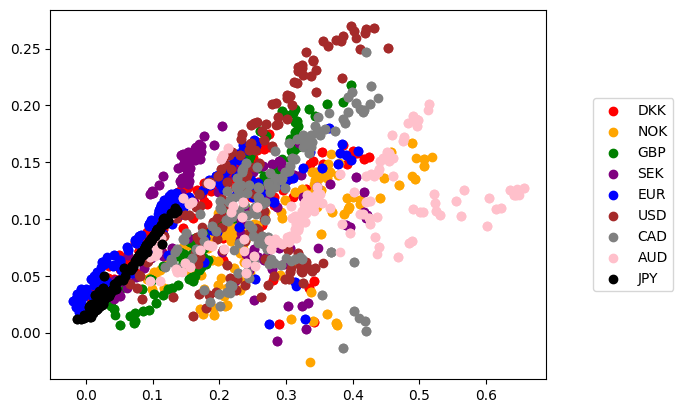

In [18]:
# code for creating 2 factor latent spaces

latent_space_dk = np.array(latent_dk)
latent_space_ad = np.array(latent_ad)
latent_space_sw = np.array(latent_sw)
latent_space_nk = np.array(latent_nk)
latent_space_jy = np.array(latent_jy)
latent_space_EU = np.array(latent_EU)
latent_space_US = np.array(latent_US)
latent_space_uk = np.array(latent_uk)
latent_space_cd = np.array(latent_cd)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(latent_space_dk[:,0],latent_space_dk[:,1], c="red", label = "DKK")
ax.scatter(latent_space_nk[:,0],latent_space_nk[:,1], c="orange", label = "NOK")
ax.scatter(latent_space_uk[:,0],latent_space_uk[:,1],  c="green", label="GBP")
ax.scatter(latent_space_sw[:,0],latent_space_sw[:,1],  c="purple", label="SEK")
ax.scatter(latent_space_EU[:,0],latent_space_EU[:,1],  c="blue", label="EUR")
ax.scatter(latent_space_US[:,0],latent_space_US[:,1],  c="brown", label="USD")
ax.scatter(latent_space_cd[:,0],latent_space_cd[:,1],  c="grey", label="CAD")
ax.scatter(latent_space_ad[:,0],latent_space_ad[:,1], c="pink", label="AUD")
ax.scatter(latent_space_jy[:,0],latent_space_jy[:,1],  c="black", label="JPY")
ax.legend(loc = "center left", bbox_to_anchor=(1.08,0.5))
fig.savefig("latent2fiae_w5",bbox_inches='tight')

In [ ]:
# code for creating 3 factor latent plot
latent_space_dk = np.array(latent_space_dk)
latent_space_ad = np.array(latent_space_ad)
latent_space_sw = np.array(latent_space_sw)
latent_space_nk = np.array(latent_space_nk)
latent_space_jy = np.array(latent_space_jy)
latent_space_EU = np.array(latent_space_EU)
latent_space_US = np.array(latent_space_US)
latent_space_uk = np.array(latent_space_uk)
latent_space_cd = np.array(latent_space_cd)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(latent_space_dk[:,0],latent_space_dk[:,1], latent_space_dk[:,2], c="red", label = "DKK")
ax.scatter(latent_space_nk[:,0],latent_space_nk[:,1], latent_space_nk[:,2], c="orange", label = "NOK")
ax.scatter(latent_space_uk[:,0],latent_space_uk[:,1], latent_space_uk[:,2], c="green", label="GBP")
ax.scatter(latent_space_sw[:,0],latent_space_sw[:,1], latent_space_sw[:,2], c="purple", label="SEK")
ax.scatter(latent_space_EU[:,0],latent_space_EU[:,1], latent_space_EU[:,2], c="blue", label="EUR")
ax.scatter(latent_space_US[:,0],latent_space_US[:,1], latent_space_US[:,2], c="brown", label="USD")
ax.scatter(latent_space_cd[:,0],latent_space_cd[:,1], latent_space_cd[:,2], c="grey", label="CAD")
ax.scatter(latent_space_ad[:,0],latent_space_ad[:,1], latent_space_ad[:,2], c="pink", label="AUD")
ax.scatter(latent_space_jy[:,0],latent_space_jy[:,1], latent_space_jy[:,2], c="black", label="JPY")
ax.legend(loc = "center left", bbox_to_anchor=(1.08,0.5))
#fig.savefig("latent2fiae_w5",bbox_inches='tight')


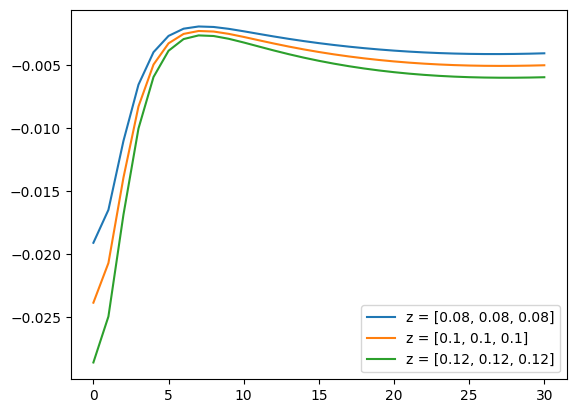

In [21]:
x = torch.tensor([0.1,0.1,0.1]) 
x1 = torch.tensor([0.12,0.12,0.12]) 
x2 = torch.tensor([0.08,0.08,0.08]) 

test = []
test1 = []
test2= []

for i in maturities:
        test.append(AE_model.decoder((torch.cat((x, torch.tensor([i]))))).detach().numpy())
        test1.append(AE_model.decoder((torch.cat((x1, torch.tensor([i]))))).detach().numpy())
        test2.append(AE_model.decoder((torch.cat((x2, torch.tensor([i]))))).detach().numpy())
plt.plot(test2,label = "z = [0.08, 0.08, 0.08]")
plt.plot(test, label = "z = [0.1, 0.1, 0.1]")
plt.plot(test1,label = "z = [0.12, 0.12, 0.12]")
plt.legend()
plt.savefig("newyieldae")

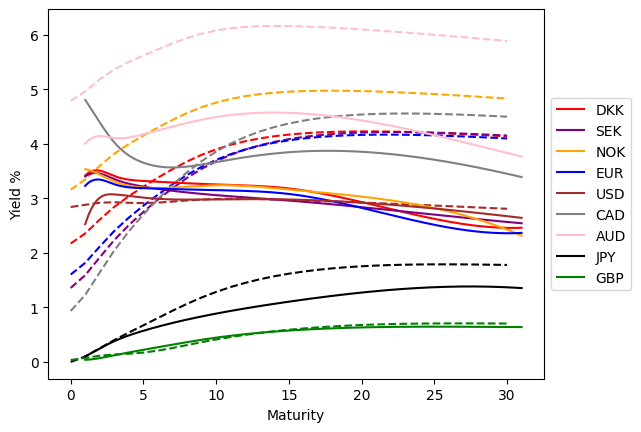

In [15]:

# code for creating yield curves, calls research module for bootstrapping

dk_data = data_train["dk"]
uk_data = data_train["uk"]
sw_data = data_train["sw"]
nk_data = data_train["nk"]
EU_data = data_train["EU"]
US_data = data_train["US"]
ad_data = data_train["ad"]
jy_data = data_train["jy"]
cd_data = data_train["cd"]
"""
dk_data = data_test["dk"]
sw_data = data_test["sw"]
nk_data = data_test["nk"]
EU_data = data_test["EU"]
ad_data = data_test["ad"]
jy_data = data_test["jy"]
cd_data = data_test["cd"]"""

init_guess = np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])

boot_yield_curve_dk = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, dk_data[0].astype(float), 1))
boot_yield_curve_sw = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, sw_data[0].astype(float), 1))
boot_yield_curve_nk = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, nk_data[0].astype(float), 1))
boot_yield_curve_EU = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, EU_data[0].astype(float), 1))
boot_yield_curve_US = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, US_data[0].astype(float), 1))
boot_yield_curve_cd = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, cd_data[0].astype(float), 1))
boot_yield_curve_ad = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, ad_data[0].astype(float), 1))
boot_yield_curve_jy = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, jy_data[0].astype(float), 1))
boot_yield_curve_uk = Research.Curve(swap_maturities,Research.get_result(Research.objective_fct, init_guess, swap_maturities, uk_data[0].astype(float), 1))



plt.plot(maturities, yield_curve_dk[0][0].detach().numpy()*100, color="red", ls='--')
plt.plot(maturities, yield_curve_sw[0][0].detach().numpy()*100, color = "purple" , ls='--')
plt.plot(maturities, yield_curve_nk[0][0].detach().numpy()*100, color = "orange", ls='--')
plt.plot(maturities, yield_curve_EU[0][0].detach().numpy()*100, color = "blue", ls='--')
plt.plot(maturities, yield_curve_US[0][0].detach().numpy()*100, color = "brown",  ls='--')
plt.plot(maturities, yield_curve_cd[0][0].detach().numpy()*100, color = "grey",  ls='--')
plt.plot(maturities, yield_curve_ad[0][0].detach().numpy()*100, color = "pink",  ls='--')
plt.plot(maturities, yield_curve_jy[0][0].detach().numpy()*100, color = "black",  ls='--')
plt.plot(maturities, yield_curve_uk[0][0].detach().numpy()*100,color = "green", ls='--')

plt.plot(boot_yield_curve_dk.x_values, boot_yield_curve_dk.y_values*100,label = "DKK", color="red")
plt.plot(boot_yield_curve_sw.x_values, boot_yield_curve_sw.y_values*100, label = "SEK",color = "purple" )
plt.plot(boot_yield_curve_nk.x_values, boot_yield_curve_nk.y_values*100,label = "NOK",  color = "orange")
plt.plot(boot_yield_curve_EU.x_values, boot_yield_curve_EU.y_values*100, label = "EUR", color = "blue")
plt.plot(boot_yield_curve_US.x_values, boot_yield_curve_US.y_values*100,label = "USD",  color = "brown")
plt.plot(boot_yield_curve_cd.x_values,boot_yield_curve_cd.y_values*100,label = "CAD",  color = "grey")
plt.plot(boot_yield_curve_ad.x_values,boot_yield_curve_ad.y_values*100, label = "AUD", color = "pink")
plt.plot(boot_yield_curve_jy.x_values,boot_yield_curve_jy.y_values*100,label = "JPY",  color = "black")
plt.plot(boot_yield_curve_uk.x_values,boot_yield_curve_uk.y_values*100,label = "GBP", color = "green") 
#plt.title("Swap Rates vs Predicted Swap Rates")
plt.xlabel("Maturity")
plt.ylabel("Yield %")
plt.legend(loc = "center left", bbox_to_anchor=(1,0.5))
plt.savefig("2finnaew5_yield", bbox_inches='tight')

In [ ]:
# code for creating comparisions plot between constructed swaps and data swaps

"""dk_data = data_train["dk"]
uk_data = data_train["uk"]
sw_data = data_train["sw"]
nk_data = data_train["nk"]
EU_data = data_train["EU"]
US_data = data_train["US"]
ad_data = data_train["ad"]
jy_data = data_train["jy"]
cd_data = data_train["cd"]


plt.plot(swap_maturities, dk_data[83], color = "red", label = "DKK")
plt.plot(swap_maturities, pred_swaps_dk[83][0].detach().numpy(),color = "red", ls = '--' )

plt.plot(swap_maturities, sw_data[83], color = "purple", label = "SEK")
plt.plot(swap_maturities, pred_swaps_sw[83][0].detach().numpy(), color = "purple", ls = '--')
plt.plot(swap_maturities, nk_data[83], color = "orange", label= "NOK")
plt.plot(swap_maturities, pred_swaps_nk[83][0].detach().numpy(), color = "orange", ls = '--')
plt.plot(swap_maturities, EU_data[83], color = "blue", label="EUR")
plt.plot(swap_maturities, pred_swaps_EU[83][0].detach().numpy(), color = "blue", ls = '--')
plt.plot(swap_maturities, US_data[83], color = "brown", label="USD")
plt.plot(swap_maturities, pred_swaps_US[83][0].detach().numpy(), color = "brown", ls = '--')
plt.plot(swap_maturities, cd_data[83], color = "grey", label="CAD")
plt.plot(swap_maturities, pred_swaps_cd[83][0].detach().numpy(), color = "grey", ls = '--')
plt.plot(swap_maturities, ad_data[83], color = "pink", label="AUD")
plt.plot(swap_maturities, pred_swaps_ad[83][0].detach().numpy(), color = "pink", ls = '--')
plt.plot(swap_maturities, jy_data[83], color = "black",label="JPY")
plt.plot(swap_maturities, pred_swaps_jy[83][0].detach().numpy(), color = "black", ls = '--')
plt.plot(swap_maturities, uk_data[83], color ="green", label = "GBP")
plt.plot(swap_maturities, pred_swaps_uk[83][0].detach().numpy(),color = "green", ls= "--") #uk 28 interesting
plt.legend(loc = "center left", bbox_to_anchor=(1,0.5))
#plt.title("Swap Rates vs Predicted Swap Rates")
plt.xlabel("Maturity")
plt.ylabel("Swap Rate")
plt.savefig("2fitaew5_train_83",bbox_inches='tight')
"""
dk_data = data_test["dk"]
sw_data = data_test["sw"]
nk_data = data_test["nk"]
EU_data = data_test["EU"]
ad_data = data_test["ad"]
jy_data = data_test["jy"]
cd_data = data_test["cd"]


plt.plot(swap_maturities, dk_data[0], color = "red", label = "DKK")
plt.plot(swap_maturities, pred_swaps_dk[0][0].detach().numpy(),color = "red", ls = '--' )

plt.plot(swap_maturities, sw_data[0], color = "purple", label = "SEK")
plt.plot(swap_maturities, pred_swaps_sw[0][0].detach().numpy(), color = "purple", ls = '--')
plt.plot(swap_maturities, nk_data[0], color = "orange", label= "NOK")
plt.plot(swap_maturities, pred_swaps_nk[0][0].detach().numpy(), color = "orange", ls = '--')
plt.plot(swap_maturities, EU_data[0], color = "blue", label="EUR")
plt.plot(swap_maturities, pred_swaps_EU[0][0].detach().numpy(), color = "blue", ls = '--')


plt.plot(swap_maturities, cd_data[0], color = "grey", label="CAD")
plt.plot(swap_maturities, pred_swaps_cd[0][0].detach().numpy(), color = "grey", ls = '--')
plt.plot(swap_maturities, ad_data[0], color = "pink", label="AUD")
plt.plot(swap_maturities, pred_swaps_ad[0][0].detach().numpy(), color = "pink", ls = '--')
plt.plot(swap_maturities, jy_data[0], color = "black",label="JPY")
plt.plot(swap_maturities, pred_swaps_jy[0][0].detach().numpy(), color = "black", ls = '--')


plt.legend(loc = "center left", bbox_to_anchor=(1,0.5))
#plt.title("Swap Rates vs Predicted Swap Rates")
plt.xlabel("Maturity")
plt.ylabel("Swap Rate")
plt.savefig("2fitaew5_test2_0",bbox_inches='tight')

In [ ]:
# in the following code blocks there is code to create mu, sigma, rho and short rate plot, if you want to plot these, go to the block
# containing the calls to the model you want to see and use the x_train_full data set

In [ ]:
#mu1 plots
"""
result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(mu1_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(mu1_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(mu1_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(mu1_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(mu1_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(mu1_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(mu1_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(mu1_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(mu1_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("mu_1 for all currencies")"""

In [ ]:
#mu2 plots

"""result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(mu2_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(mu2_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(mu2_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(mu2_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(mu2_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(mu2_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(mu2_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(mu2_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(mu2_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("mu_2 for all currencies")"""

In [ ]:
#mu3 plots, only usable for 3-factor models
"""
result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(mu3_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(mu3_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(mu3_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(mu3_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(mu3_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(mu3_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(mu3_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(mu3_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(mu3_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("mu_3 for all currencies")"""

In [ ]:
# rho plots, only usable for 2-factor models
"""
result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(rho_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(rho_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(rho_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(rho_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(rho_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(rho_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(rho_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(rho_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(rho_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("rho for all currencies")"""

In [ ]:
# rho12 plots, only usable for 3-factor models
"""
result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(rho12_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(rho12_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(rho12_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(rho12_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(rho12_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(rho12_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(rho12_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(rho12_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(rho12_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("rho12 for all currencies")"""

In [ ]:
# rho13 plots, only usable for 3-factor models
"""
result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(rho13_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(rho13_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(rho13_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(rho13_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(rho13_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(rho13_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(rho13_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(rho13_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(rho13_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("rho13 for all currencies")"""

In [ ]:
# rho23 plots, only usable for 3-factor models
"""
result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(rho23_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(rho23_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(rho23_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(rho23_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(rho23_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(rho23_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(rho23_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(rho23_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(rho23_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("rho23 for all currencies")"""

In [ ]:
#sigma1 plots
"""result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(sigma1_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(sigma1_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(sigma1_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(sigma1_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(sigma1_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(sigma1_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(sigma1_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(sigma1_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(sigma1_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("sigma1 for all currencies")"""

In [ ]:
#sigma2 plots
"""result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(sigma2_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(sigma2_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(sigma2_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(sigma2_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(sigma2_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(sigma2_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(sigma2_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(sigma2_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(sigma2_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("sigma2 for all currencies")"""

In [ ]:
#sigma3 plots, only usable for 3-factor models
"""result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(sigma3_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(sigma3_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(sigma3_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(sigma3_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(sigma3_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(sigma3_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(sigma3_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(sigma3_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(sigma3_nk)])


plt.plot(result_array_sw, c = "black", label = "sw")
plt.plot(result_array_dk, c = "orange", label = "dk")
plt.plot(result_array_ad, c = "purple", label = "ad")
plt.plot(result_array_uk, c = "red", label = "uk")
plt.plot(result_array_jy, c = "grey", label= "jy")
plt.plot(result_array_US, c = "yellow", label = "US")
plt.plot(result_array_EU, c = "green", label = "EU")
plt.plot(result_array_cd, c = "pink", label = "cd")
plt.plot(result_array_nk, c = "blue", label = "nk")

plt.legend()
plt.title("sigma3 for all currencies")"""

/var/folders/gp/xnwph00x4rsf4yv8z9z7ghtw0000gn/T/ipykernel_83399/1098788494.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_sw), freq='M'),result_array_sw, c = "purple", label = "sw")
/var/folders/gp/xnwph00x4rsf4yv8z9z7ghtw0000gn/T/ipykernel_83399/1098788494.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_dk), freq='M'),result_array_dk, c = "red", label = "dk")
/var/folders/gp/xnwph00x4rsf4yv8z9z7ghtw0000gn/T/ipykernel_83399/1098788494.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_ad), freq='M'),result_array_ad, c = "pink", label = "ad")
/var/folders/gp/xnwph00x4rsf4yv8z9z7ghtw0000gn/T/ipykernel_83399/1098

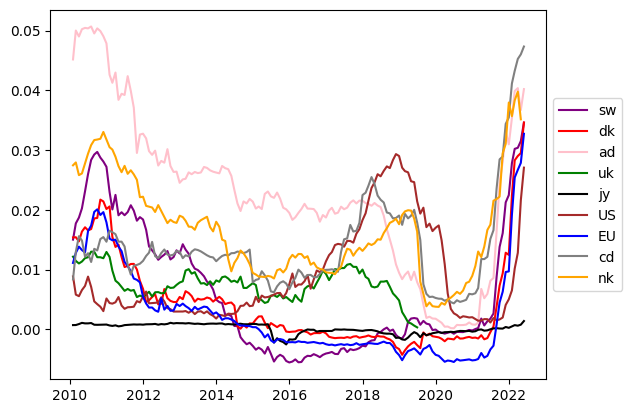

In [27]:
# short rate plot
"""result_array_dk = np.array([tensor_item.item() for tensor_item in reversed(short_rates_dk)])
result_array_ad = np.array([tensor_item.item() for tensor_item in reversed(short_rates_ad)])
result_array_uk = np.array([tensor_item.item() for tensor_item in reversed(short_rates_uk)])
result_array_sw = np.array([tensor_item.item() for tensor_item in reversed(short_rates_sw)])
result_array_jy = np.array([tensor_item.item() for tensor_item in reversed(short_rates_jy)])
result_array_US = np.array([tensor_item.item() for tensor_item in reversed(short_rates_US)])
result_array_EU = np.array([tensor_item.item() for tensor_item in reversed(short_rates_EU)])
result_array_cd = np.array([tensor_item.item() for tensor_item in reversed(short_rates_cd)])
result_array_nk = np.array([tensor_item.item() for tensor_item in reversed(short_rates_nk)])



plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_sw), freq='M'),result_array_sw, c = "purple", label = "sw")
plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_dk), freq='M'),result_array_dk, c = "red", label = "dk")
plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_ad), freq='M'),result_array_ad, c = "pink", label = "ad")
plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_uk), freq='M'),result_array_uk, c = "green", label = "uk")
plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_jy), freq='M'),result_array_jy, c = "black", label= "jy")
plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_US), freq='M'),result_array_US, c = "brown", label = "US")
plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_EU), freq='M'),result_array_EU, c = "blue", label = "EU")
plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_cd), freq='M'),result_array_cd, c = "grey", label = "cd")
plt.plot(pd.date_range(start='2010-01-01', periods=len(result_array_nk), freq='M'),result_array_nk, c = "orange", label = "nk")

plt.legend(loc = "center left", bbox_to_anchor=(1,0.5))
#plt.title("Short rates for all currencies")
plt.savefig("3finnaew5_shortrate",bbox_inches='tight')"""

In [ ]:
# extracting code
"""for name, param in AE_model.named_parameters():
    
    if name == "encoder.0.weight":
        print("here")
        weights = param
print("weights", weights)

numpy_weights = weights.detach().numpy()

#print(numpy_weights.shape)
inv_weights = np.linalg.pinv(numpy_weights)

result_sigma1_dk = np.array([tensor_item.item() for tensor_item in sigma1_dk])
result_sigma1_ad = np.array([tensor_item.item() for tensor_item in sigma1_ad])
result_sigma1_uk = np.array([tensor_item.item() for tensor_item in sigma1_uk])
result_sigma1_sw = np.array([tensor_item.item() for tensor_item in sigma1_sw])
result_sigma1_jy = np.array([tensor_item.item() for tensor_item in sigma1_jy])
result_sigma1_US = np.array([tensor_item.item() for tensor_item in sigma1_US])
result_sigma1_EU = np.array([tensor_item.item() for tensor_item in sigma1_EU])
result_sigma1_cd = np.array([tensor_item.item() for tensor_item in sigma1_cd])
result_sigma1_nk = np.array([tensor_item.item() for tensor_item in sigma1_nk])



result_sigma2_dk = np.array([tensor_item.item() for tensor_item in sigma2_dk])
result_sigma2_ad = np.array([tensor_item.item() for tensor_item in sigma2_ad])
result_sigma2_uk = np.array([tensor_item.item() for tensor_item in sigma2_uk])
result_sigma2_sw = np.array([tensor_item.item() for tensor_item in sigma2_sw])
result_sigma2_jy = np.array([tensor_item.item() for tensor_item in sigma2_jy])
result_sigma2_US = np.array([tensor_item.item() for tensor_item in sigma2_US])
result_sigma2_EU = np.array([tensor_item.item() for tensor_item in sigma2_EU])
result_sigma2_cd = np.array([tensor_item.item() for tensor_item in sigma2_cd])
result_sigma2_nk = np.array([tensor_item.item() for tensor_item in sigma2_nk])

result = np.vstack((result_sigma1_US[0], result_sigma2_US[0]))

plt.plot([1,2,3,5,10,15,20,30],inv_weights@result/10)"""
